X-Ray interaction with matter phantom
Xray spectra at different energies generated using python module xpecgen ; it is set for a Tungston target, 22 mm added filtration 100 cm air gap.
Detail of xpecgen are available at https://github.com/Dih5/xpecgen


In [1]:
#import time
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from IPython.display import clear_output

In [2]:
def read_data():
    global mu_liver
    mu_liver = pd.read_csv("mu_values_tissues/mu_liver_complete.csv", header=0)
    global mu_fat
    mu_fat = pd.read_csv("mu_values_tissues/mu_fat_complete.csv", header=0)
    global mu_air
    mu_air = pd.read_csv("mu_values_tissues/mu_air_complete.csv", header=0)
    global KV_quant_factor
    KV_quant_factor = pd.read_csv("KV_mAs_5_PercentRule/data_KV_mAs.csv", header = 0)
    

In [3]:
read_data()

In [4]:
def spectra(x):
    keV=x
    with open('spectra/'+str(keV)+"_spectrum.csv") as f, open('destination.csv', 'w') as fw: 
        writer(fw, delimiter=',').writerows(zip(*reader(f, delimiter=',')))
    global spectral_data
    spectral_data = pd.read_csv("destination.csv", header=None)
    #return (spectral_data)

    

In [5]:
def spectra(x):
    keV=x
    global spectral_data
    spectral_data = pd.read_csv('spectra/'+str(keV)+"_spectrum.csv", header=None)
    spectral_data = spectral_data.T
    #return (spectral_data)

In [6]:
#spectra(40)
#spectral_data


In [7]:
#spectral_data

Sample the spectrum. Choose KeV values at random between min and max photon energies (column one) and choose random values for intensity min to max


In [8]:
def spectral_limits():
    global maxInt
    maxInt=max(spectral_data[1])
    maxInt
    global maxKeV
    maxKeV=max(spectral_data[0])
    maxKeV
    

In [9]:
#spectral_limits()

In [10]:
#Here is the Monte Carlo sampling".

def monte_carlo_sample(mAs, maxKev):
    factor=(spectral_data.shape[0]-1)/maxKeV
    global mc_spectrum
    mc_spectrum = pd.DataFrame([])
    i=0
    while i < 10*mAs:
        randX= np.random.uniform(low=0.0,high=maxKeV,size=1)
        randY= np.random.uniform(low=0.0,high=maxInt,size=1)
        if float(randY)<spectral_data[1][round(factor*float(randX))] and float(randY)>0:
            i=i+1
            temp=pd.DataFrame([round(float(randX))])
            mc_spectrum=pd.concat([mc_spectrum,temp])
    mc_spectrum = mc_spectrum.rename(columns={0 :'keV'})
    return(mc_spectrum)


In [11]:
def get_spectra_dependent_mu():
    global spect_dependent_mu
    spect_dependent_mu=pd.merge(mc_spectrum,mu_fat,on='keV',how='left')


In [12]:
def create_images(mAs,maxKeV):
    mAs_factor = KV_quant_factor.loc[KV_quant_factor['KV']== maxKeV]['mAs']
    mAs = mAs * mAs_factor.item()
    print(mAs_factor.item())
    global total_nr_photons
    total_nr_photons = 10*100*mAs# factor 10 is in the montecarlo script so evene mAs 1 has 10 photons, 100 is 10X10 pixles
    
    global image_fat
    image_fat = np.zeros((10,10))
    for  i in range (0,10,1):
        print("working on pixel row " + str(i+1)  +" out of 10 for image 1 of 3     ", end='\r')
        for j in range (0,10,1):
            monte_carlo_sample(mAs, maxKeV)
            spect_dependent_mu=pd.merge(mc_spectrum,mu_fat,on='keV',how='left')
            image_fat[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
        #time.sleep(1)
    print("",end='\n')
    #image_fat

    global image_liver
    image_liver = np.zeros((10,10))
    for  i in range (0,10,1):
        for j in range (0,10,1):
            monte_carlo_sample(mAs, maxKeV)
            spect_dependent_mu=pd.merge(mc_spectrum,mu_liver,on='keV',how='left')
            image_liver[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
            print("working on pixel row " + str(i+1)  +" out of 10 for image 2 of 3     ", end='\r')
        #time.sleep(1)
    print("",end='\n')
    #image_liver

    global image_air
    image_air = np.zeros((10,10))
    for  i in range (0,10,1):
        for j in range (0,10,1):
            monte_carlo_sample(mAs, maxKeV)
            spect_dependent_mu=pd.merge(mc_spectrum,mu_air,on='keV',how='left')
            image_air[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
            print("working on pixel row " + str(i+1)  +" out of 10 for image 3 of 3     ", end='\r')
    print("",end='\n')
    print("",end='\n')
    #time.sleep(1)
    #clear_output()    

In [13]:
#df.loc[df['column_name'] == some_value]
#test=KV_quant_factor.loc[KV_quant_factor['KV']==41]['mAs']
#test[0]
KV_quant_factor
#df.loc[df['col1'] == value]
test=KV_quant_factor.loc[KV_quant_factor['KV'] == 46]['mAs']
test.item()

2.1202964411326084

In [14]:
#fig = plt.figure
#plt.imshow(image_air, cmap='gray')
#plt.show()

In [15]:
def display_images():
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(image_liver, cmap='gray_r',vmin=0,vmax=1)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(image_fat, cmap='gray_r',vmin=0,vmax=1)
    ax3 = fig.add_subplot(1,3,3)
    ax3.axes.set_xlabel("Air")
    ax3.imshow(image_air, cmap='gray_r',vmin=0,vmax=1)

    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax1.axes.set_title('Liver')

    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.axes.set_title('Fat')

    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.axes.set_title('Air')

    liver_mean = image_liver.mean()
    liver_std = image_liver.std()
    liver_snr = 10*np.log10(liver_mean/liver_std) # in db
    fat_mean = image_fat.mean()
    fat_std = image_fat.std()
    fat_snr = 10*np.log10(fat_mean/fat_std) # in db
    air_mean = image_air.mean()
    air_std = image_air.std()
    air_snr = 10*np.log10(air_mean/air_std) # in db


    print("Liver; Mean pixel value,",liver_mean)
    print("Liver; SNR, ", liver_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*liver_mean)), end='\n\n')
    print("Fat; Mean pixel value,",fat_mean)
    print("Fat; SNR, ", fat_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*fat_mean)), end='\n\n')
    print("Air; Mean pixel value,",air_mean)
    print("Air; SNR, ", air_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*air_mean)), end='\n\n')
    
    contrast = np.log10(fat_mean/liver_mean)
    print ("Fat to liver contrast,", contrast)




In [16]:
def phantom(mAs, KVp):
    if mAs <1:
        raise ValueError("mAs should be an integer between 1 and 10 inclusive")
    #if mAs >10:
    #    raise ValueError("mAs should be an integer between 1 and 10 inclusive")
    if KVp < 40:
        raise ValueError("KVp should be an integer between 40 and 120 inclusive")
    if KVp > 120:
        raise ValueError("KVp should be an integer between 40 and 120 inclusive")
    #mAs=100
    maxKeV=KVp
    #mAs=100
    #load_packages()
    read_data()
    spectra(KVp)
    spectral_limits()
    create_images(mAs,KVp)
    display_images()
    

1.0
working on pixel row 10 out of 10 for image 1 of 3     
working on pixel row 10 out of 10 for image 2 of 3     
working on pixel row 10 out of 10 for image 3 of 3     

Liver; Mean pixel value, 0.21948561904038721
Liver; SNR,  4.88620548534085 db
Total number of photons reaching detector  219

Fat; Mean pixel value, 0.39943710165152746
Fat; SNR,  8.244765214467789 db
Total number of photons reaching detector  399

Air; Mean pixel value, 0.9983434422258424
Air; SNR,  33.74600222143444 db
Total number of photons reaching detector  998

Fat to liver contrast, 0.2600423317642577


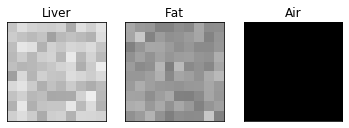

In [17]:
phantom(1,40)

In [ ]:
phantom(4,40)

1.0
working on pixel row 10 out of 10 for image 1 of 3     
working on pixel row 10 out of 10 for image 2 of 3     
working on pixel row 10 out of 10 for image 3 of 3     

Liver; Mean pixel value, 0.20733807517756844
Liver; SNR,  4.324843585507518 db
Total number of photons reaching detector  207

Fat; Mean pixel value, 0.3746645560784575
Fat; SNR,  7.123246386882514 db
Total number of photons reaching detector  374

Air; Mean pixel value, 0.9982468098609556
Air; SNR,  33.44465794614183 db
Total number of photons reaching detector  998

Fat to liver contrast, 0.2569635475737612


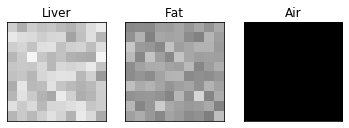

In [18]:
phantom(1,40)

In [ ]:
phantom(1,50)